In [2]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt
from scipy.stats import norm

In [7]:
directory = "D:\Anytime-Sequential-Halving\StaticBaselines\AnySH"

In [4]:
#Function to calculate the Agresti-Coull confidence interval
def calculate_CI_Agresti_Coull(wins, n, confidence):

    #get z value based on confidence level
    alpha = 1 - confidence
    z = norm.ppf(1 - (alpha/2))
    #z should be 1.96 for 95% confidence

    #Modified n and p values for Agresti-Coull method
    n_dash = n + z**2
    p_dash = (wins + z**2/2)/n_dash

    #Calculate standard error
    standard_error = sqrt(p_dash/n_dash * (1 - p_dash))

    #Uncertainy value for +- the p_dash
    uncertainty = z * standard_error

    #Upper and lower bounds
    lower_bound = max(0.0, p_dash - uncertainty)
    upper_bound = min(1.0, p_dash + uncertainty)

    p_dash = p_dash * 100  # Convert to percentage
    lower_bound = lower_bound * 100  # Convert to percentage
    upper_bound = upper_bound * 100  # Convert to percentage
    uncertainty = uncertainty * 100  # Convert to percentage

    return p_dash, lower_bound, upper_bound, uncertainty

In [20]:
#Configurations
agents = {"BestSplit": "Standard Variant", "BestSplitDouble": "Double Iteration Variant",}
games = ["Yavalath", "Breakthrough", "Amazons", "Clobber"]
budgets = [1000, 20000, 50000]
values = [1.0, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9]

data = []

#Pattern to match the score line
pattern = re.compile(r"Winning score.*?N=\d+,\s+mean=([0-9.]+)")

#Iterate through all agents, games, budgets and values
for agent_key, agent_folder in agents.items():
    for game in games:
        for budget in budgets:
            for value in values:
                value_str = f"{value:}"
                file_path = os.path.join(directory, agent_key, game, f"budget_{budget}", f"value_{value_str}.out")
                
                with open(file_path, "r") as f:
                    content = f.read()

                matches = pattern.findall(content)

                #Get the last mean value from the file
                win_rate = float(matches[-1])

                data.append({
                    "agent": agent_key,
                    "game": game,
                    "budget": budget,
                    "value": value,
                    "win_percentage": round(win_rate * 100, 2)
                })


df = pd.DataFrame(data)
df = df.sort_values(by=["agent", "game", "budget", "value"])
df = df.reset_index(drop=True)
#Change agent names
df["agent"] = df["agent"].map(agents)

df.head()

,agent,game,budget,value,win_percentage
0,Standard Variant,Amazons,1000,1.00,58.0
1,Standard Variant,Amazons,1000,1.15,60.0
2,Standard Variant,Amazons,1000,1.30,52.0
3,Standard Variant,Amazons,1000,1.45,50.0
4,Standard Variant,Amazons,1000,1.60,43.0


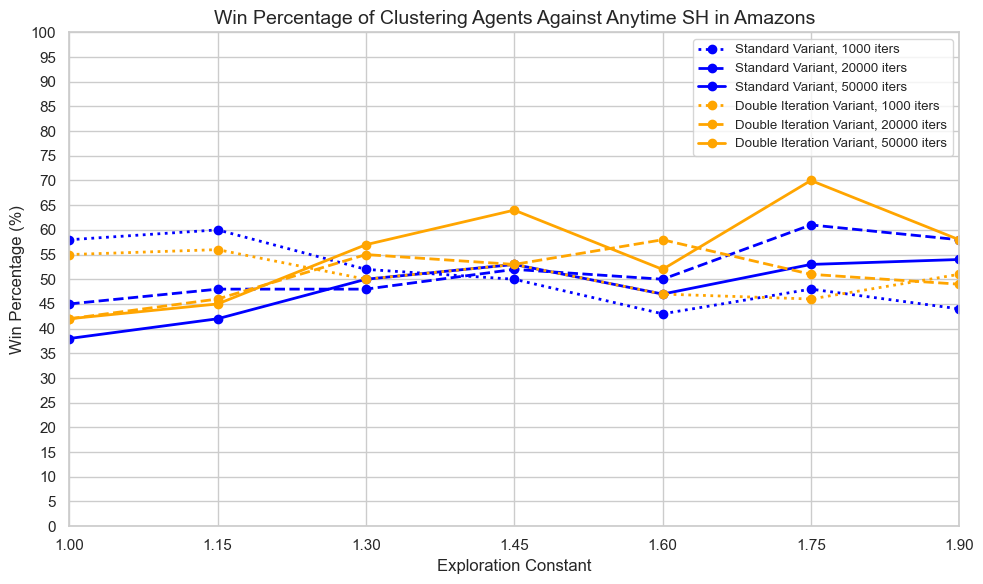

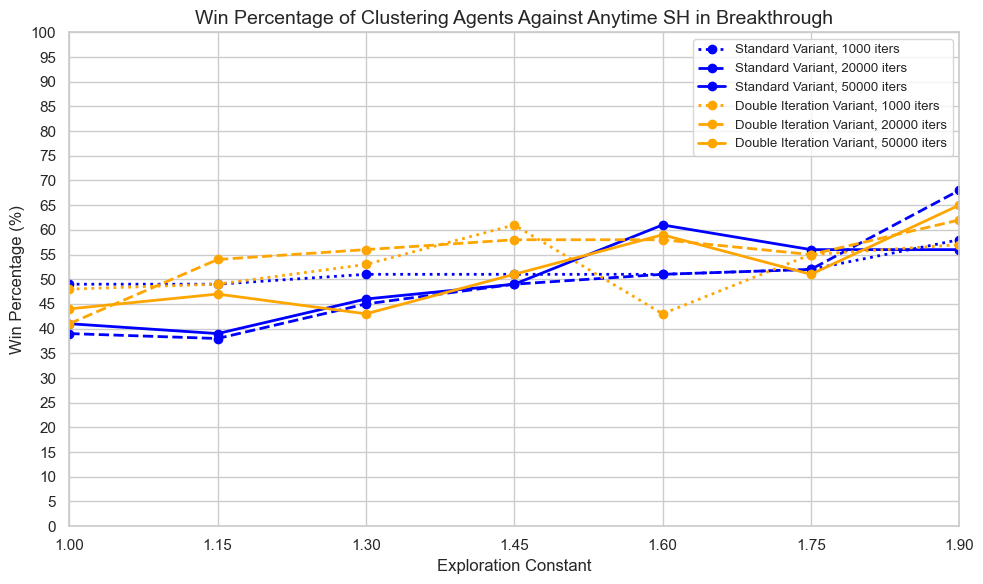

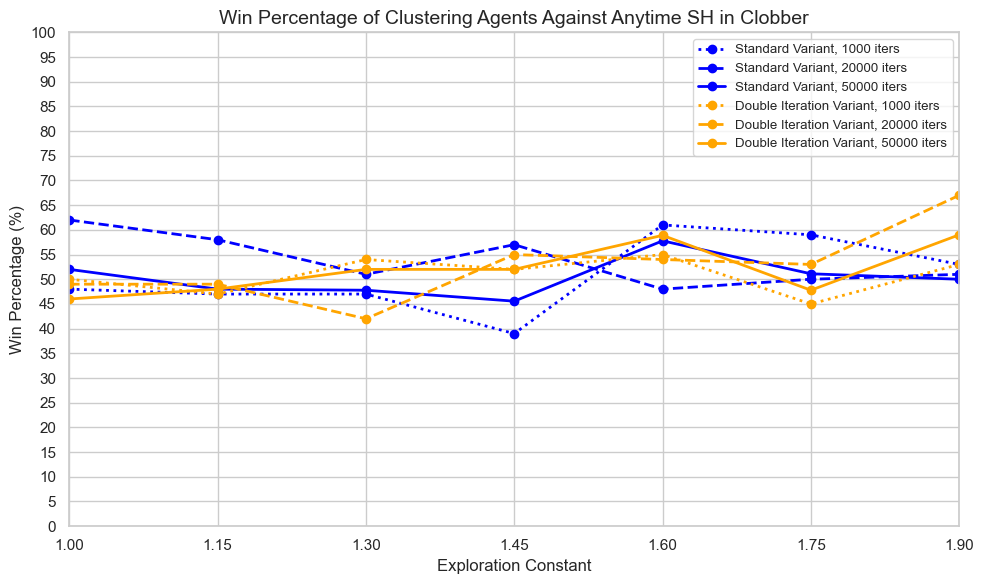

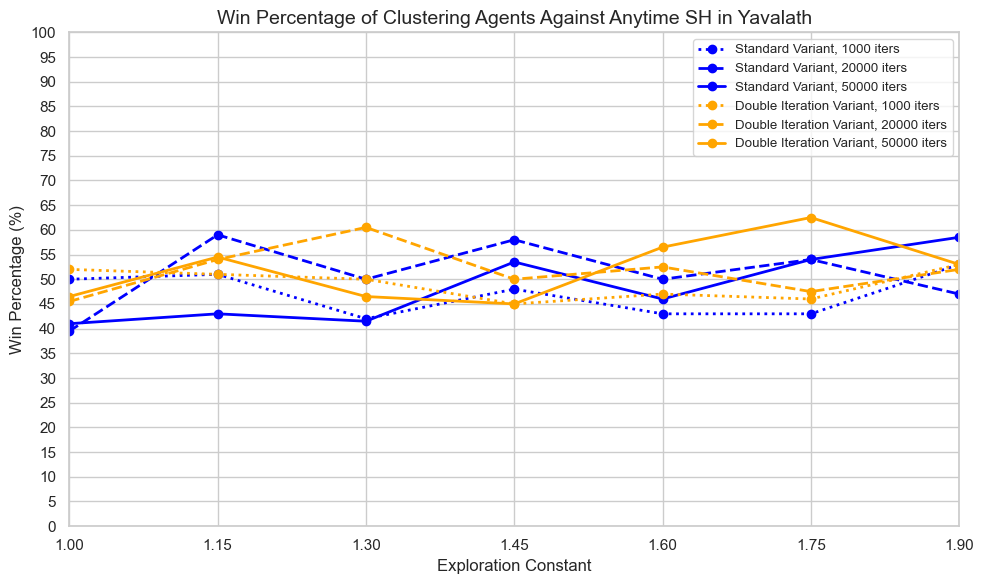

In [23]:
sns.set_theme(style="whitegrid")

#Set color and style for the plots
agentColors = {"Standard Variant": "blue", "Double Iteration Variant": "orange"}
budget_styles = {
    1000: "dotted",
    20000: "dashed",
    50000: "solid"
}

#Make 4 plots, one for each game
for game in df["game"].unique():
    plt.figure(figsize=(10, 6))
    game_df = df[df["game"] == game]

    for agent in df["agent"].unique():
        for budget in sorted(df["budget"].unique()):
            subset = game_df[(game_df["agent"] == agent) & (game_df["budget"] == budget)]

            plt.plot(
                subset["value"],
                subset["win_percentage"],
                label=f"{agent}, {budget} iters",
                color=agentColors.get(agent, "gray"),
                linestyle=budget_styles.get(budget, "solid"),
                linewidth=2,
                marker="o"
            )

    plt.title(f"Win Percentage of Clustering Agents Against Anytime SH in {game}", fontsize=14)
    plt.xlabel("Exploration Constant", fontsize=12)
    plt.ylabel("Win Percentage (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.xlim(1.0, 1.9)
    plt.xticks(values)
    plt.yticks(np.linspace(0, 100, 21))
    plt.legend(fontsize=9.5)
    plt.tight_layout()
    plt.show()